In [1]:

from glob import glob

import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data
## Import

In [2]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    df.drop("Unnamed: 0", axis = 1, inplace = True)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(["floor", "expenses"], axis=1, inplace=True)
    
    # Drop low and high cardinality
    df.drop(["operation", "property_type", "currency", "properati_url"], axis=1, inplace=True)
    
    # Drop Leaky columns
    df.drop(["price",
             "price_aprox_local_currency",
             "price_per_m2",
             "price_usd_per_m2"], 
            axis=1,
            inplace=True)
    
    # Drop multicollinearity columns
    df.drop(["surface_total_in_m2", "rooms"], axis=1, inplace=True)

    
    return df

In [3]:
files = glob("C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires *.csv")
files

['C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 1.csv',
 'C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 2.csv',
 'C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 3.csv',
 'C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 4.csv',
 'C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires 5.csv']

In [4]:
# Check your work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

In [5]:
# frames = []
# for file in files:
#    df = wrangle(file)
#    frames.append(df)

In [6]:
frames = [wrangle(file) for file in files]

In [7]:
frames[2]

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
7,120000.0,55.0,-34.616004,-58.470506,Villa General Mitre
20,89000.0,37.0,-34.584712,-58.444927,Palermo
21,183495.0,57.0,-34.554652,-58.493644,Saavedra
41,95000.0,47.0,-34.610581,-58.479625,Villa del Parque
43,95000.0,35.0,-34.558227,-58.458357,Belgrano
...,...,...,...,...,...
8574,145000.0,50.0,-34.553534,-58.436914,Belgrano
8577,149000.0,50.0,-34.583538,-58.405318,Recoleta
8582,118000.0,40.0,-34.568917,-58.457627,Belgrano
8593,77800.0,36.0,-34.622790,-58.394566,San Cristobal


In [8]:
type(frames[1])

pandas.core.frame.DataFrame

In [9]:
# Check your work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

In [10]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constituci�n
4,90000.0,50.0,-34.610610,-58.412511,Once


In [11]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 17, f"`df` has too many columns: {df.shape[1]}"

# Explore

The first thing we need to consider when trying to use all the features df is missing values. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

Take a look at the output from df.info() above. Are there columns where more than half of the values are NaN? If so, those columns need to go!

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


In [13]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 15, f"`df` has too many columns: {df.shape[1]}"

The next thing we need to look out for are categorical columns with low or high cardinality. If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data.

Let's take a look at the cardinality of our features.

Calculate the number of unique values for each non-numeric feature in df.

In [14]:
df.select_dtypes("object").head()

,neighborhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constituci�n
4,Once


In [15]:
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

Here, we can see that columns like "operation" have only one value in them, while every row in "properati_url" has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

Task 2.4.6: Modify your wrangle function to drop high- and low-cardinality categorical features.

Be sure to rerun all the cells above before you continue.

Here, we can see that columns like "operation" have only one value in them, while every row in "properati_url" has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

Task 2.4.6: Modify your wrangle function to drop high- and low-cardinality categorical features.

Be sure to rerun all the cells above before you continue.

In [16]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 11, f"`df` has too many columns: {df.shape[1]}"

It's also important for us to drop any columns that would constitute leakage, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed.

Task 2.4.7: Modify your wrangle function to drop any features that would constitute leakage.

Be sure to rerun all the cells above before you continue.

In [17]:
sorted(df.columns)

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

In [18]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 7, f"`df` has too many columns: {df.shape[1]}"

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


Finally, the last issue we need to keep an eye out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

Task 2.4.8: Plot a correlation heatmap of the remaining numerical features in df. Since "price_aprox_usd" will be your target, you don't need to include it in your heatmap.

In [20]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr() 
corr

,surface_covered_in_m2,lat,lon
surface_covered_in_m2,1.000000,0.028538,0.034515
lat,0.028538,1.000000,-0.262439
lon,0.034515,-0.262439,1.000000


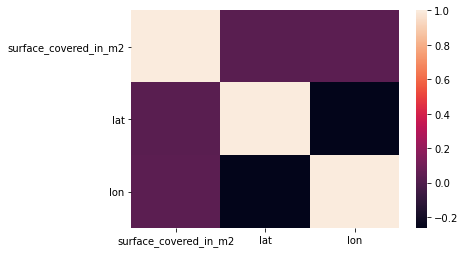

In [21]:
sns.heatmap(corr);

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


Task 2.4.9: Modify your wrangle function to remove columns so that there are no strongly correlated features in your feature matrix.

Be sure to rerun all the cells above before you continue.

In [23]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] == 5, f"`df` has the wrong number of columns: {df.shape[1]}"
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constituci�n
4,90000.0,50.0,-34.610610,-58.412511,Once


# Split Data
Task 2.4.10: Create your feature matrix X_train and target vector y_train. Your target is "price_aprox_usd". Your features should be all the columns that remain in the DataFrame you cleaned above.

In [24]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
X_train = df[features]
y_train = df[target]

In [25]:
# Check your work
assert X_train.shape == (6582, 4), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model
## Baseline

Calculate the baseline mean absolute error for your model.

In [26]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274134


# Iterate

Task 2.4.12: Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.

In [27]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [28]:
# Check your work
check_is_fitted(model[-1])

Task 2.4.13: Calculate the training mean absolute error for your predictions as compared to the true targets in y_train.

In [29]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.10719033039


Task 2.4.14: Run the code below to import your test data buenos-aires-test-features.csv into a DataFrame and generate a list of predictions using your model. Then run the following cell to submit your predictions to the grader.

In [30]:
X_test = pd.read_csv("C:\\Users\\Babar\\PycharmProject\\pythonProject\\WQ Uni Project 2\\Buenos Aires\\Buenos Aires_Test Features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

# Communicate Results
For this lesson, we've relied on equations and visualizations for communication about our model. In many data science projects, however, communication means giving stakeholders tools they can use to deploy a model — in other words, use it in action. So let's look at two ways you might deploy this model.

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output.

### Task 2.4.1: 
Create a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.

In [31]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [32]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Let's create one using Jupyter Widgets.

Task 2.4.16: Add your make_prediction to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes.

In [33]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…